# Housing prices for King County

Training a simple polynomial model on Hosing Sale data from king country [data source](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction)
As a learning exercise

In [33]:
from utils import load_data
from train import gradient_descent
from matplotlib import pyplot as plt
import numpy as np
import torch
from tqdm import notebook
import itertools
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder

In [25]:
device = 'cpu'

In [26]:
# Load data from csv into a pandas dataframe
data = load_data.load_data("./data/kc_house_data.csv")
data.drop(['date', 'id', 'lat', 'long'], axis=1, inplace=True)

# Feature Engineering
Housing prices do not tend to be linear but curve like, thus we will be engineering some polynomial features

In [27]:
labels = data['price']
engineeredData = data.copy()
engineeredData.drop(['price'], axis=1, inplace=True)

dataSquared = engineeredData.pow(2)
dataSquared.rename(lambda c: f"{c} squared", inplace=True, axis='columns')

dataCubed = engineeredData.pow(3)
dataCubed.rename(lambda c: f"{c} cubed", inplace=True, axis='columns')

# engineeredData = engineeredData.join(dataSquared).join(dataCubed)
engineeredData = engineeredData #.join(dataSquared)
engineeredData.head(5)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,1340,5650
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,1690,7639
2,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,2720,8062
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,1360,5000
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,1800,7503


# Feature Scaling


In [50]:
encoder = OneHotEncoder(handle_unknown='ignore')
# unique_zip_codes = np.unique(data['zipcode'].values)
one_hot_encoded = encoder.fit_transform([[x] for x in data['zipcode'].values])
mlp = MLPRegressor(100)
mlp.fit(one_hot_encoded, data['price'].values)

/Users/ahmed.mamdouh/projects/house-sale-king-county/env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=100)

In [52]:
out = mlp.predict(one_hot_encoded)

In [58]:
data['zip_code_encoded'] = out

In [28]:
means = engineeredData.mean()
stds = engineeredData.std()
for column in engineeredData.columns:
    engineeredData[column] = engineeredData[column] - means[column]
    engineeredData[column] = engineeredData[column] / stds[column]

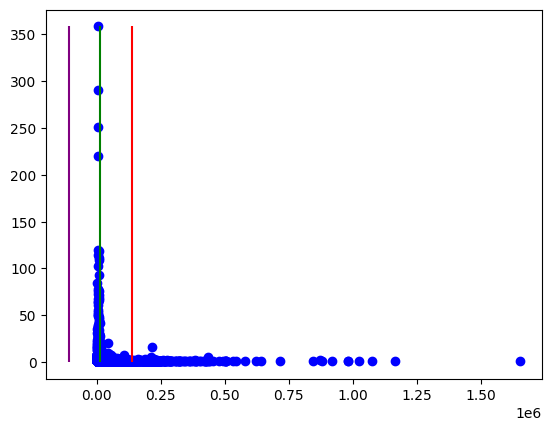

In [85]:
col = data['sqft_lot']
unique, count = np.unique(col, return_counts=True)
shift = col.mean() + 3 * col.std()
shift2 = col.mean() - 3 * col.std()
plt.scatter(unique, count, c='blue')
plt.vlines([shift, shift2, col.mean()], ymin=0, ymax = max(count), colors=['red', 'purple', 'green'])

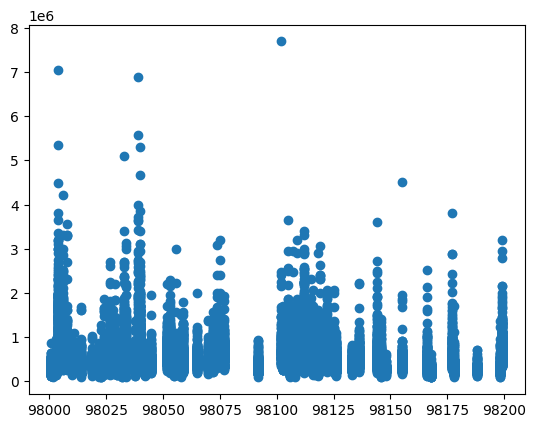

# Training Data
We have split the data into two halves, the first half will be the training data. Matrix trainingSamples contains our examples. Each row is an example and each column is a feature. Vector trainingLabels contains the labels for our training set.

In [6]:
total_rows = len(engineeredData)
trainingSetRows = int(total_rows * 0.7)
# TODO: Shuffle data before splitting train/test
trainingSamples = engineeredData[:trainingSetRows].values
trainingLabels = labels[:trainingSetRows].values[:, None]
print(f"trainingSamples shape: {trainingSamples.shape}")
print(f"trainingLabels shape: {trainingLabels.shape}")

trainingSamples shape: (15129, 16)
trainingLabels shape: (15129, 1)


# Parameters
Parameter vector w and param b


In [7]:
trainingSamples = torch.from_numpy(trainingSamples).to(torch.float32).to(device)
trainingLabels = torch.from_numpy(trainingLabels).to(torch.float32).to(device)

In [8]:
alpha = 5e-4
iterations = 50_000
batch_size = len(trainingSamples)
model = torch.nn.Linear(trainingSamples.shape[1], 1, device=device)
j_history = []
optimizer = torch.optim.SGD(model.parameters(), alpha)
loss_fn = torch.nn.MSELoss()
for _ in (prog_bar := notebook.trange(iterations, desc="learning")):
    epoch_loss = []
    for i in range(0, len(trainingLabels), batch_size):
        X = trainingSamples[i:i+batch_size]
        y = trainingLabels[i:i+batch_size]
        optimizer.zero_grad()
        prediction = model.forward(X)
        loss = loss_fn.forward(prediction, y)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    j_history.append(sum(epoch_loss) / len(epoch_loss))  # Save cost J at each iteration
    prog_bar.set_description(f"loss: {j_history[-1]:.2f}")


learning:   0%|          | 0/50000 [00:00<?, ?it/s]

In [9]:
w, b, history2 = gradient_descent(trainingSamples, trainingLabels, alpha, iterations, batch_size)

learning:   0%|          | 0/50000 [00:00<?, ?it/s]

# Plotting cost vs iterations


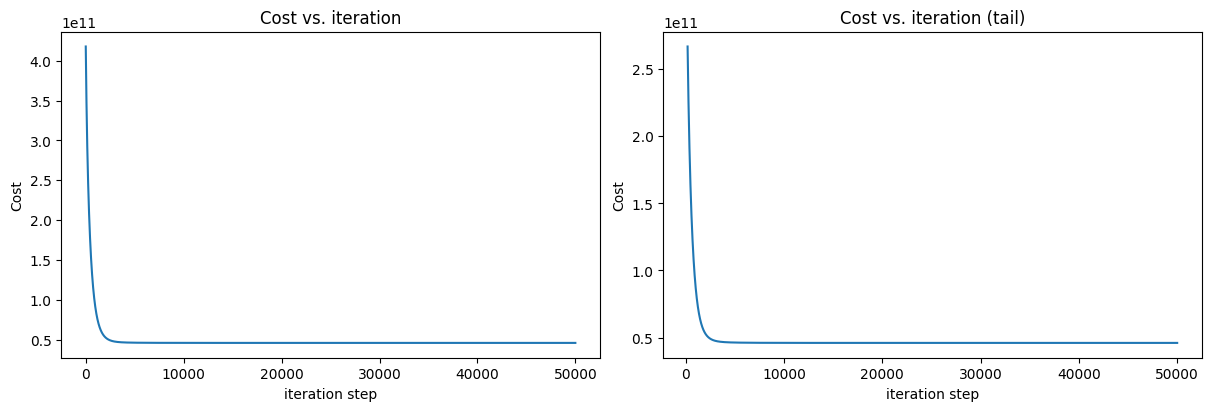

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(j_history)
tail_length = 200
ax2.plot(np.arange(tail_length, len(j_history)), j_history[tail_length:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step')
plt.show()

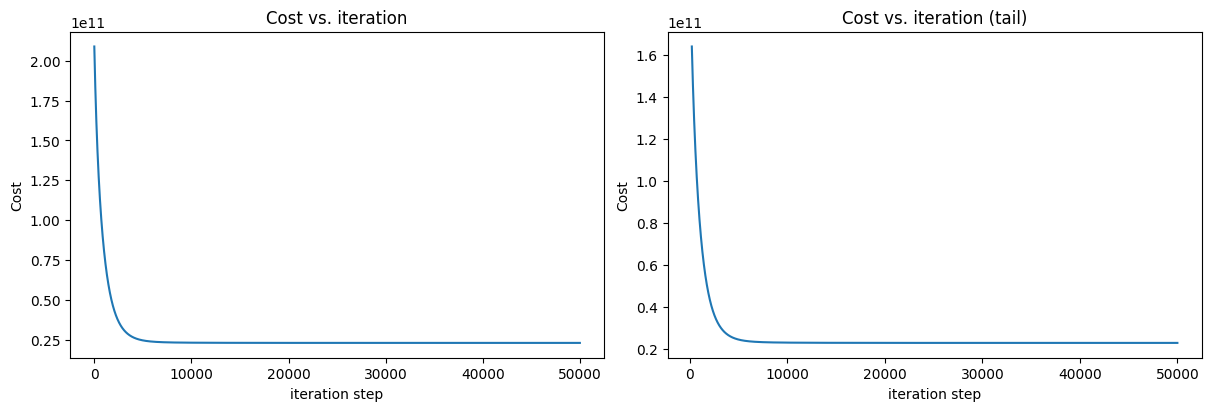

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(history2)
tail_length = 200
ax2.plot(np.arange(tail_length, len(history2)), history2[tail_length:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step')
plt.show()

In [12]:
pred = model(trainingSamples)
error = torch.square(pred - trainingLabels).sum().item() / (2 * len(pred))
print(error)

23024608104.31886


In [13]:
pred = trainingSamples @ w + b
error = torch.square(pred - trainingLabels).sum().item() / (2 * len(pred))
print(error)

23024621411.64862
